<a href="https://colab.research.google.com/github/parvbhargava/Time-Series-Forcasting-Model-Climate-change-Prediction/blob/main/ENHANCED_TIME_SERIES_FORECASTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary datasets for the model
import os

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

# Enhanced library
import jax.numpy as jnp
from jax import random

In [ ]:
!pip3 install numpyro

     |████████████████████████████████| 283 kB 14.4 MB/s 


In [ ]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(4)
assert numpyro.__version__.startswith("0.9.2")

Length of time series: 114


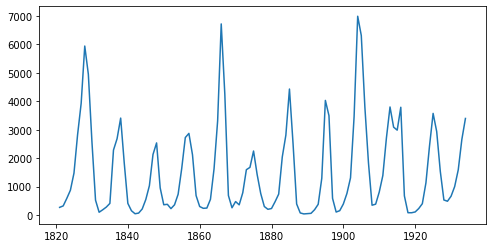

In [ ]:
# Importing the Dataset for the model
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
lynx = pd.read_csv(URL, index_col = 0)
data = lynx["value"].values
print('Length of time series:', data.shape[0])
plt.figure(figsize=(8,4))
plt.plot(lynx["time"], data)
plt.show()

In [ ]:
y_train, y_test = jnp.array(data[:80], dtype=jnp.float32), data[80:]

In [ ]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

In [ ]:
print("Lag values sorted according to their autocorrelation values:\n")
print(jnp.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according to their autocorrelation values:

[ 0 67 57 38 68  1 29 58 37 56 28 10 19 39 66 78 47 77  9 79 48 76 30 18
 20 11 46 59 69 27 55 36  2  8 40 49 17 21 75 12 65 45 31 26  7 54 35 41
 50  3 22 60 70 16 44 13  6 25 74 53 42 32 23 43 51  4 15 14 34 24  5 52
 73 64 33 71 72 61 63 62]


In [ ]:
%%time
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=4)
mcmc.run(random.PRNGKey(0), y_train, seasonality=38)
mcmc.print_summary()
samples = mcmc.get_samples()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     33.59    122.06     14.10    -99.64    152.78   1904.42      1.00
       init_s[0]     84.84    104.31     63.35    -63.06    241.40   5796.14      1.00
       init_s[1]    -20.07     70.21    -24.19   -132.36     86.35   7629.30      1.00
       init_s[2]     29.53     94.25     17.99   -118.37    164.41   6180.99      1.00
       init_s[3]    126.35    126.54    106.84    -54.97    328.29   5000.04      1.00
       init_s[4]    457.55    263.35    413.21     85.61    851.33   4543.72      1.00
       init_s[5]   1183.05    468.12   1106.27    468.69   1865.87   3179.71      1.00
       init_s[6]   2008.15    676.61   1905.43    975.97   3026.53   2285.37      1.00
       init_s[7]   3702.58   1104.04   3556.11   1915.62   5337.32   2070.79      1.00
       init_s[8]   2615.86    840.02   2501.46   1322.06   3889.29   2113.34      1.00
       init_s[9]    967.28    455.56    89

In [ ]:
# Forecasting

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=38, future=34)[
    "y_forecast"
]

In [ ]:
y_pred = jnp.mean(forecast_marginal, axis=0)
sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 64.16, rmse: 1252.14


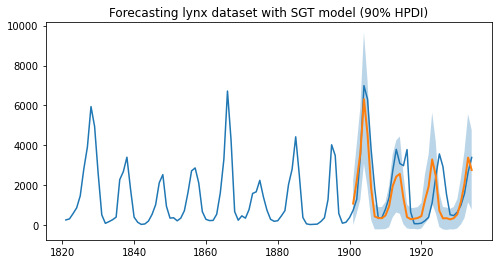

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(lynx["time"], data)
t_future = lynx["time"][80:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting lynx dataset with SGT model (90% HPDI)")
plt.show()